# Trees

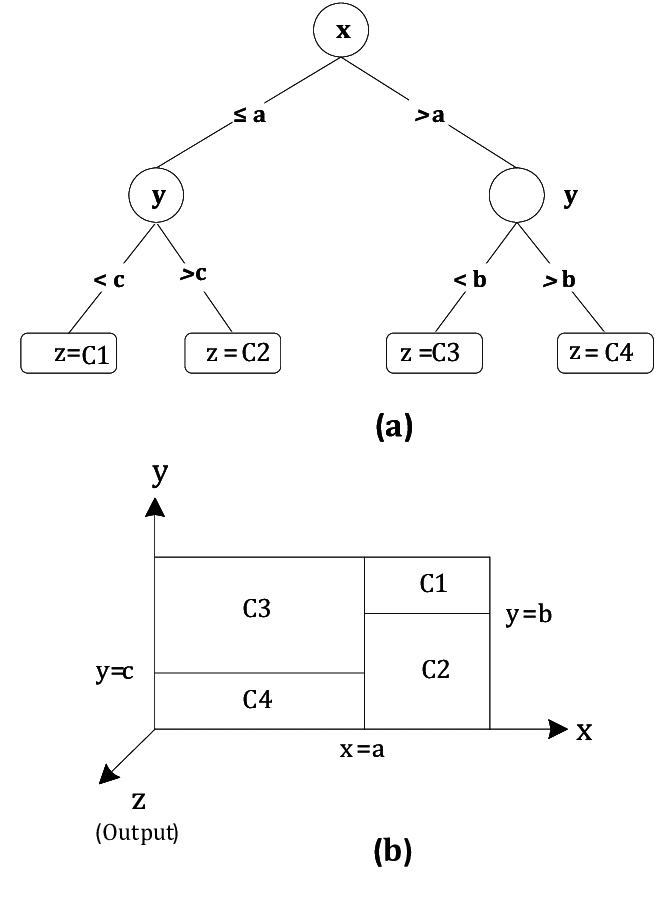
Decision trees consist of nodes and leaves. We start with the entire training data set and then recursively split it into two parts to create smaller and smaller regions. Each split is called a decision node, and each terminal end of the tree is a leaf and is tied to a certain region of the sample space.

Trees are non-parametric, meaning they do not make assumptions about the distribution of the data being classified. It is a
discriminative classifier as it does not rely on set boundaries for classification.

Decision trees can be fast, not all nodes need to be hit when a sample is being classified, so decisions can be made in $Log_2N$ where N = num leaves

* Another advantage of the decision tree is interpretability. As we will see shortly, the tree can be converted to a set of IF-THEN rules that are easily understandable. For this reason, decision trees are very popular and sometimes preferred over more accurate but less interpretable methods.

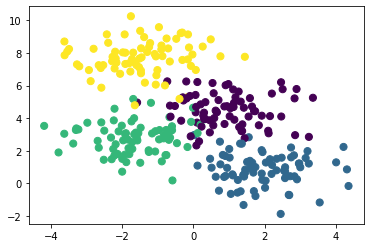

In [3]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);

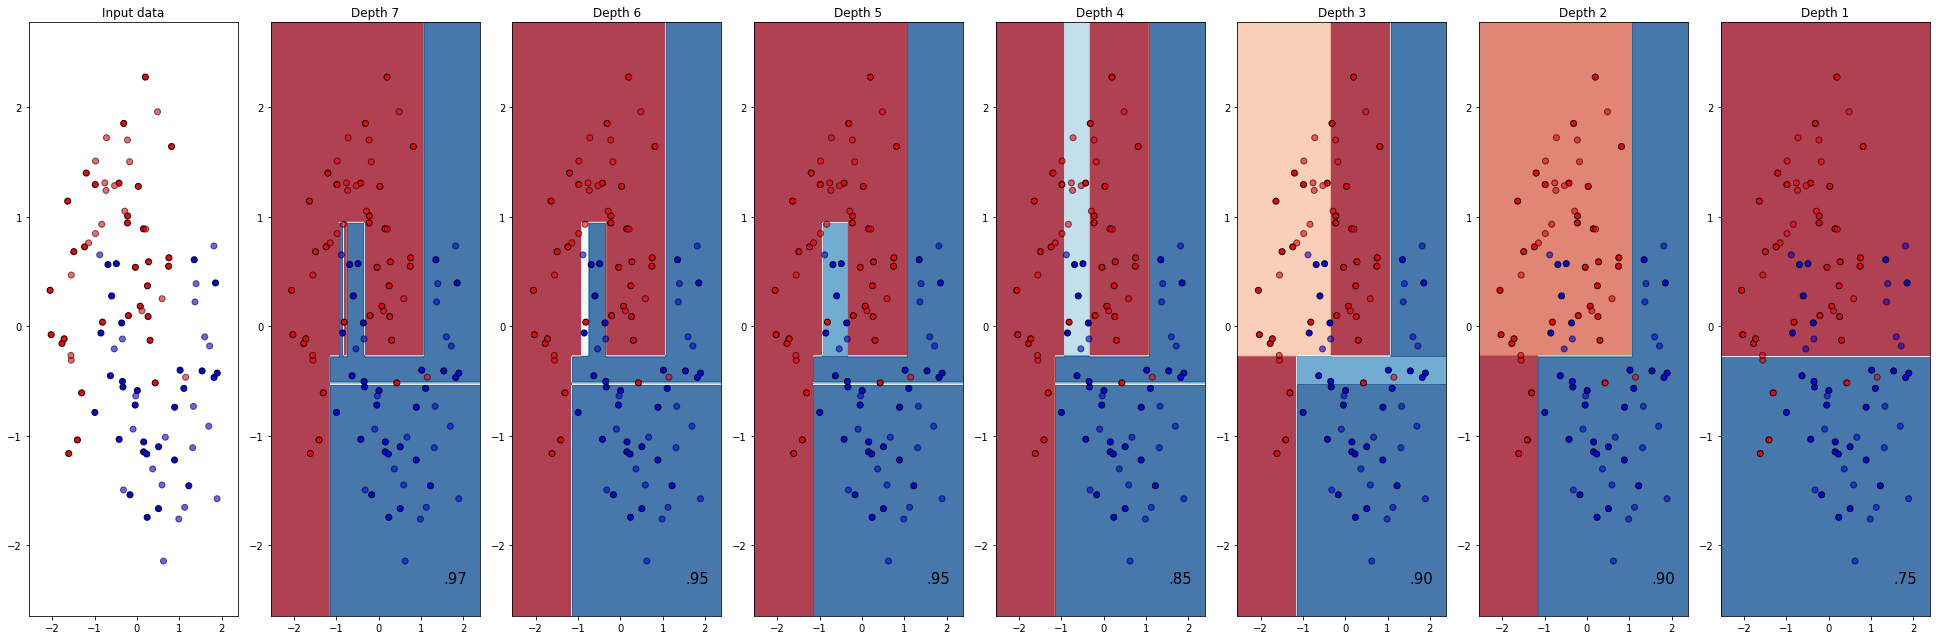

In [19]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
#Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

names = [
    "Depth 7",
    "Depth 6",
    "Depth 5",
    "Depth 4",
    "Depth 3",
    "Depth 2",
    "Depth 1",
]

classifiers = [
    DecisionTreeClassifier(max_depth=7),
    DecisionTreeClassifier(max_depth=6),
    DecisionTreeClassifier(max_depth=5),
    DecisionTreeClassifier(max_depth=4),
    DecisionTreeClassifier(max_depth=3),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=1)
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
#     make_circles(noise=0.2, factor=0.5, random_state=1),
#     linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )
#         ax.set_xlim(xx.min(), xx.max())
#         ax.set_ylim(yy.min(), yy.max())

        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

## Overfitting

A Tree can  overfit if it gets to deep and the leaves get to small. Strategies to avoid this include enforcing a minimum size on the number of elements in each leafe.
**Pruning Conditions** are enforced to stop a tree from growing further.

In [ ]:
# code for regularization

## Splitting Models - Impurity and Information Criteria

There are many models to measure the quality of the split. The most common impurity criteria are:

1. **Entropy** is an information gain split criterion. 

$$I_H = -\sum_{j=1}^c p_j \log_2(p_j)$$

where $p_i$ is the proportion of samples that belong to class $i$ for a particular node. Note the logarithm is base 2 because we are imagining that we encode everything using binary digits (bits), and we define $0 \log 0 = 0$.

Suppose that we have a set of positive and negative examples of some feature (where the feature can only take 2 values: positive and negative). If all of the examples are positive, then we don't get any extra information from knowing the value of the feature for any particular example, since whatever the value of the feature, the example will be positive. Thus, the entropy of that feature is 0. However, if the feature separates the examples into 50% positive and 50% negative, then the amount of entropy is at a maximum, and knowing about that feature is very useful to us. The basic concept is that it tells us how much extra information we would get from knowing the value of that feature.

2. **Gini Index** is an impurity split criterion.

$$I_G = 1 - \sum_{j=1}^c p_j^2$$

where $p_i$ is the proportion of samples that belong to class $i$ for a particular node.

The *impurity* in the name suggests that the aim of the decision tree is to have each leaf node represent a set of data points that are in the same class, so that there are no mismatches. This is known as *purity*. If a leaf is pure then all of the training data within it have just one class. In which case, if we count the number of data points at the node (or better, the fraction of the number of data points) that belong to a class i (call it $p_i$), then it should be 0 for all except one value of $i$. So suppose that you want to decide on which feature to choose for a split. The algorithm loops over the different features and checks how many points belong to each class.

## TensorFlow

# Bagging & Boosting

## Ensembles of Estimators: Random Forests

This notion - that multiple overfitting estimators can be combined to reduce the effect of this overfitting - is what underlies an ensemble method called **bagging**. 

**Bagging**, which stands for **bootstrap aggregating**, makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a **random forest**.

* Note: a *bootstrap sample* is a sample taken from the original data set with replacement. The bootstrap sample is the same size as the original.

This type of bagging classification can be done manually using Scikit-Learn's ```BaggingClassifier``` meta-estimator, as shown here:

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

NameError: name 'X' is not defined

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness. For example, when determining which feature to split on, the randomized tree might select from among the top several features. You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ```RandomForestClassifier``` estimator, which takes care of all the randomization automatically. All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## Summary of Random Forests

Random forest is a type of *ensemble estimators*. Random forests are a powerful method with several **advantages**:

* Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.

* The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the ```predict_proba()``` method).

* The non-parametric model is extremely flexible, and can thus perform well on tasks that are underfit by other estimators.

A primary **disadvantage** of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the meaning of the classification model, random forests may not be the best choice.

from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [ ]:
# Source: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

# figure parameters
h = .02  # step size in the mesh
figure = plt.figure(figsize=(20, 9))

# set up classifiers
n_neighbors = 5
classifiers = [KNeighborsClassifier(n_neighbors, weights='uniform', metric='euclidean'), \
               KNeighborsClassifier(n_neighbors, weights='distance', metric='euclidean'),\
               DecisionTreeClassifier(max_depth=5),\
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
              ]
names = ["k-NN Uniform", "k-NN Weighted","Decision Tree", "Random Forest"]

# Put together Data Sets
n_samples = 300
X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 1*rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0,n_samples=n_samples),
            make_circles(noise=0.2, factor=0.5, random_state=1,n_samples=n_samples),
            linearly_separable,
            make_blobs(random_state=1,cluster_std=[3.0,4.0,2.5],n_samples=n_samples)
            ]

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = ListedColormap(['cornflowerblue','yellowgreen','orange']) #plt.cm.RdBu
    cm_bright = ListedColormap(['blue','olivedrab','chocolate'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k',label='Training points')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], marker='P', c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k',label='Test points')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], marker='P', c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

**Boosting** - when misclassified samples are given more imporatance in the following iterations when training a model

* Adaboost - a type of boosting

Random Forest TensorFlow example: https://colab.research.google.com/drive/1WgRkT6CwhEoyZq30UjDzDj6kQzLVs75T?usp=sharing

**Note**: this only works on Linux for now

# PCA

    * To understand Lagrange optimization: https://www.youtube.com/watch?v=yuqB-d5MjZA&ab_channel=KhanAcademy
 The Lagrangian function $$\mathcal{L}$$ should equal 0 when the derivatives are taken

# LDA

**Linear Discriminant Analysis (LDA)** can be used as a technique for feature extraction to increase the computational efficiency and reduce the degree of overfitting due to the curse of dimensionality in nonregularized models.

* The general concept behind LDA is very similar to PCA, whereas PCA attempts to find the orthogonal component axes of maximum variance in a dataset; the goal in LDA is to find the feature subspace that optimizes class separability.

* Both LDA and PCA are linear transformation techniques that can be used to reduce the number of dimensions in a dataset; PCA is an **unsupervised** algorithm, whereas LDA is a **supervised** algorithm.

* One **assumption** in LDA is that the data is normally distributed. Also, we assume that the classes have identical covariance matrices and that the features are statistically independent of each other. 

### Steps of LDA

1. Standardize the $d$-dimensional dataset ($d$ is the number of features).

2. For each class, compute the $d$-dimensional mean vector $\mathbf{m}$.

3. Construct the between-class scatter matrix $S_B$ and the within-class scatter matrix $S_w$.

4. Compute the eigenvectors and corresponding eigenvalues of the matrix $S_W^{-1}S_B$.

5. Choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues to construct a $d\times k$-dimensional transformation matrix $W$; the eigenvectors are the columns of this matrix.

6. Project the samples onto the new feature subspace using the transformation matrix $W$.

Each mean vector $\mathbf{m}_i$ stores the mean feature value $\mu_m$ with respect to the samples of class $i$:

$$\mathbf{m}_i = \frac{1}{n_i} \sum_{x\in D_i}^c \mathbf{x}_m$$

Using the mean vectors, we can now compute the within-class scatter matrix $S_W$:

$$S_W = \sum_{i=1}^c S_i$$

This is calculated by summing up the individual scatter matrices $S_i$ of each individual class $i$:

$$S_i = \sum_{x\in D_i}^c (\mathbf{x}-\mathbf{m}_i)(\mathbf{x}-\mathbf{m}_i)^T$$

We should scale the individual scatter matrices $S_i$ before we sum them up as scatter matrix $S_W$. When we divide the scatter matrices by the number of class samples $N_i$, we can see that computing the scatter matrix is in fact the same as
computing the covariance matrix $\Sigma_i$. The covariance matrix is a normalized version of the scatter matrix:

$$\Sigma_i = \frac{1}{N_i} S_W = \frac{1}{N_i} \sum_{x\in D_i}^c (\mathbf{x}-\mathbf{m}_i)(\mathbf{x}-\mathbf{m}_i)^T $$

After we have computed the scaled within-class scatter matrix (or covariance matrix), we can move on to the next step and compute the between-class scatter matrix $S_B$:

$$S_B = \sum_{i=1}^c N_i (\mathbf{m}_i - \mathbf{m})(\mathbf{m}_i - \mathbf{m})^T$$

Here, $\mathbf{m}$ is the overall mean that is computed, including samples from all classes.



TODO: finish and understand LDA derivation,
TODO: LDA projectino of MNIST daaset onto 2 dimmensions.

# SVM

Let's start with the two-class linearly separable task and then we will extend the method to more general cases where data are not separable. Let $\phi(x_i)$, $i=1,2,\dots,N$, be the feature vectors of the training set, $X$, and corresponding target values $t_1, t_2, \cdots, t_N$ where $t_n\in\{-1,1\}$. These belong to either of two classes, $C_1$, $C_2$, which are *assumed to be linearly separable*.

The goal, once more, is to design a hyperplane

$$y(x) = w^T\phi(x) + b = 0$$

that classifies correctly all the training vectors.

Because the training data is linearly separable in the feature space, by definition there exists at least one choice of the parameters $w$ and $b$ such that $y(x)$ satisfies $y(x_n)>0$ for points having $t_n = +1$ and $y(x_n)<0$ for points having $t_n = -1$, so that $t_ny(x_n) > 0$ for all training data points.

Furthermore, we are only interested in solutions for which all data points are correctly classified, so that $t_n y(x_n) > 0, \forall n$. Thus the distance of a point $x_n$ to the decision surface is given by

$$\frac{t_n y(x_n)}{\Vert w\Vert} = \frac{t_n \left(w^t\phi(x_n) + b\right)}{\Vert w\Vert}$$

The margin is given by the perpendicular distance to the closest point $x_n$ from the data set, and we wish to optimize the parameters $w$ and $b$ in order to maximize this distance. Thus the maximum margin solution is found by solving

$$\arg_{w,b}\max \left\{\frac{1}{\Vert w\Vert}\min_n \left[t_n(w^T\phi(x_n)+b)\right]\right\}$$

where the factor $\frac{1}{\Vert w\Vert}$ is taken outside the optimization over $n$ because $w$ does not depend on $n$.

* Direct solution of this optimization problem would be very complex, and so we shall convert it into an equivalent problem that is much easier to solve. 

* To do this we note that if we make the rescaling $w\rightarrow \kappa w$ and $b\rightarrow \kappa b$, then the distance from any point $x_n$ to the decision surface, given by $\frac{t_n y(x_n)}{\Vert w\Vert}$, is unchanged. We can use this freedom to set

$$t_n(w^T\phi(x_n)+b) = 1$$

for the point that is closest to the surface, called the **support vectors**. In this case, all data points will satisfy the constraints

$$t_n(w^T\phi(x_n)+b) \geq 1, n=1, 2, \dots, N$$

* This is known as the canonical representation of the decision hyperplane. 

* In the case of data points for which the equality holds (support vectors), the constraints are said to be active, whereas for the remainder they are said to be inactive. 

* By definition, there will always be at least one active constraint, because there will always be a closest point, and once the margin has been maximized there will be at least two active constraints.

The optimization problem then simply requires that we maximize $\Vert w\Vert^{-1}$, which is equivalent to minimizing $\Vert w\Vert^2$, and so we have to solve the optimization problem

\begin{align}
&\arg_{w,b}\min \frac{1}{2} \Vert w\Vert^2 \\
& \text{subject to } t_n(w^T\phi(x_n)+b) \geq 1
\end{align}

In order to solve this constrained optimization problem, we introduce *Lagrange multipliers* $a_n \geq 0$, with one multiplier an for each of the constraints, giving the Lagrangian function

$$L(w,b,a) = \frac{1}{2}\Vert w\Vert^2 - \sum_{n=1}^N a_n \left(t_n(w^T\phi(x_n)+b) - 1\right)$$

* Note the minus sign in front of the Lagrange multiplier term, because we are minimizing with respect to $w$ and $b$, and maximizing with respect to $a$. 

Setting the derivatives of $L(w, b, a)$ with respect to $w$ and $b$ equal to zero, we obtain the following two conditions:

$$w = \sum_{n=1}^N a_nt_n\phi(x_n)$$

$$ 0 = \sum_{n=1}^N a_nt_n$$

Eliminating $w$ and $b$ from $L(w, b, a)$ using these conditions then gives the *dual representation* of the maximum margin problem in which we maximize

$$\tilde{L}(a) = \sum_{n=1}^N a_n - \sum_{n=1}^N\sum_{m=1}^N a_n a_m t_n t_m k(x_n, x_m)$$

with respect to a subject to the constraints

$$a_n \geq 0, n=1,2,\dots, N$$

$$\sum_{n=1}^N a_nt_n = 0$$

Here the kernel function is defined by $k(x,y) = \phi(x)^T \phi(y)$. 

* This takes the form of a quadratic programming problem in which we optimize a quadratic function of a subject to a set of inequality constraints.

* The solution to a quadratic programming problem in $M$ variables in general has computational complexity that is $O(M^3)$. In going to the dual formulation we have turned the original optimization problem into the dual problem, which has $N$ variables. 
    * For a fixed set of basis functions whose number $M$ is smaller than the number $N$ of data points, the move to the dual problem appears disadvantageous. However, it allows the model to be reformulated using kernels, and so the maximum margin classifier can be applied efficiently to feature spaces whose dimensionality exceeds the number of data points, including infinite feature spaces. 
    * The kernel formulation also makes clear the role of the constraint that the kernel function $k(x,y)$ be positive definite, because this ensures that the Lagrangian function $\tilde{L}(a)$ is bounded below, giving rise to a well defined optimization problem.
    
In order to classify new data points using the trained model, we evaluate the sign of $y(x) = w^T\phi(x) + b$. This can be expressed in terms of the parameters $\{a_n\}$ and the kernel function by substituting for $w$ to give

$$y(x) = \sum_{n=1}^N a_n t_n k(x,x_n) + b$$

* A constrained optimization of this form satisfies the Karush-Kuhn-Tucker (KKT) conditions, which in this case require that the following three properties hold

\begin{align}
& a_n \geq 0 \\
& t_n y(x_n) - 1 \geq 0 \\
& a_n \left(t_n y(x_n) - 1\right) = 0
\end{align}

Thus for every data point, either $a_n = 0$ or $t_n y(x_n) = 1$. 
* Any data point for which $a_n = 0$ will not appear in the sum of $y(x)$ and hence plays no role in making predictions for new data points. 

* The remaining data points are called **support vectors**, and because they satisfy $t_n y(x_n) = 1$, they correspond to points that lie on the maximum margin hyperplanes in feature space. 

* Once the model is trained, a significant proportion of the data points can be discarded and only the support vectors retained!

Having solved the quadratic programming problem and found a value for $a$, we can then determine the value of the threshold parameter $b$ by noting that any support vector $x_n$ satisfies $t_n y(x_n) = 1$.

$$t_n \left(\sum_{m\in S}a_m t_m k(x_n,x_m) + b\right) = 1$$

where $S$ denotes the set of indices of the support vectors. Although we can solve this equation for $b$ using an arbitrarily chosen support vector $x_n$, a numerically more stable solution is obtained by first multiplying through by $t_n$, making use of $t_n^2 = 1$, and then averaging these equations over all support vectors and solving for $b$ to give

$$b = \frac{1}{N_S} \sum_{n\in S}\left(t_n - \sum_{m\in S}a_m t_m k(x_n, x_m)\right)$$

where $N_S$ is the total number of support vectors.

### Example